# Laboratorio 7 Modelos Generativos de Redes

Introduciremos los grafos de Erdos-Renyi como primer modelo aleatorio utilizado para simular la generación de redes. Los modelos aleatorios son redes artificiales que siguen un principio lógico para ser generados. Este principio se basa en simplificaciones con el fin de aproximar los fenómenos naturales que forman las conexiones entre los distintos agentes de una red.


Contenidos:

1.   Modulo Random.
2.   Erdös-Rényi modelo de grafo aleatorio.
3.   Propiedades esperadas grafo Erdös-Rényi.
4.   Camino más corto grafo Erdös-Rényi.
5.   Clustering grafo Erdös-Rényi.

In [1]:
import itertools
import random

%matplotlib inline
import networkx as nx

Para cada uno de los modelos presentados en este tutorial, presentamos el algoritmo, una implementación de ejemplo y la función de código de NetworkX correspondiente para generar el modelo. Las implementaciones proporcionadas en este tutorial están escritas para que sean entendibles y no necesariamente eficiente; es mejor utilizar las funciones de NetworkX al realizar un análisis real.


# Modulo Random

Muchos modelos de redes dependen de la aleatoriedad en sus algoritmos generativos. El módulo random de Python proporciona cuatro funciones clave que son útiles al codificar modelos de redes.





## `random.random`
A menudo, en un algoritmo, necesitamos que algo suceda con alguna probabilidad  𝑝 . La forma canónica de decidir si ocurre o no tal evento es generar un número aleatorio uniforme 𝑟  entre 0 y 1, y si  𝑟<𝑝 , entonces ocurre el evento. La función random.random() devuelve precisamente ese número aleatorio en el intervalo [0, 1).

Para un ejemplo simple, considera una moneda injusta que sale cara el 75% del tiempo. Podemos escribir el siguiente código para lanzar una moneda así 10 veces, informando el resultado cada vez:

In [2]:

p_heads = 0.75

for _ in range(10):
    r = random.random()
    outcome = 'Heads' if r < p_heads else 'Tails'
    print(outcome)

Heads
Heads
Heads
Tails
Heads
Heads
Heads
Heads
Tails
Heads


Como esperaríamos de un proceso aleatorio, ejecutar la celda anterior de nuevo generará una secuencia diferente de lanzamientos; cada uno se genera de forma independiente.


## `random.choice`

 Cuando tenemos una población de elecciones discretas y necesitamos seleccionar una al azar, usamos [random.choice()](https://docs.python.org/3.7/library/random.html#random.choice). Por ejemplo, en lugar de "[eeny, meeny, miny, moe](https://en.wikipedia.org/wiki/Eeny,_meeny,_miny,_moe)," podemos usar random.choice para elegir un nombre al azar:



In [3]:
names = ['Alice', 'Bob', 'Charlie', 'David', 'Eva']

random_name = random.choice(names)
print(random_name)

David


## `random.sample`

Si tenemos una colección y necesitamos seleccionar más de un elemento sin reemplazo, usamos [random.sample()](https://docs.python.org/3.7/library/random.html#random.sample). Por ejemplo, para elegir dos nodos al azar de los nodos en un grafo, podemos usar lo siguiente:


In [4]:
G = nx.cycle_graph(5)
random.sample(G.nodes, 2)

[0, 1]

## `random.choices`

Usamos [random.choices()](https://docs.python.org/3.7/library/random.html#random.choices) cuando necesitamos elegir un elemento de una colección y las probabilidades de seleccionar cada elemento no son idénticas.

Por ejemplo, supongamos que Alice, Bob y Carol participan en un sorteo. Alice compró un boleto, Bob compró tres boletos y Carol compró cuatro boletos. Podemos simular diez sorteos diferentes de este sorteo, reemplazando el boleto sorteado cada vez, con el siguiente código:




In [5]:
participants = ['Alice', 'Bob', 'Carol']
ticket_counts = [1, 3, 4]

for _ in range(10):
    winner = random.choices(participants, weights=ticket_counts, k=1)[0]
    print(f"The winner is: {winner}")

The winner is: Bob
The winner is: Bob
The winner is: Bob
The winner is: Carol
The winner is: Carol
The winner is: Carol
The winner is: Carol
The winner is: Alice
The winner is: Carol
The winner is: Bob


Al ejecutar la celda anterior, deberíamos obtener lo que esperamos: Carol gana el sorteo con mayor frecuencia, con Bob ganando algunas veces y Alice ganando ocasionalmente. ¡Por supuesto, este resultado depende de la suerte en el sorteo!

Al especificar el argumento de palabra clave `k=`, podemos elegir *k* elementos de la colección *con reemplazo*.
Además los pesos entregados no necesariamente deben ser enteros, puede ser cualquier variable numérica.




In [6]:
winners = random.choices(participants, weights=ticket_counts, k=5)
print("Winners:", winners)

Winners: ['Carol', 'Carol', 'Bob', 'Bob', 'Carol']


#Erdös-Rényi modelo de grafo aleatorio.

El modelo de red aleatoria, formulado por Erdös-Rényi, tiene dos parámetros: el número de nodos $N$ y la probabilidad de enlace $p$. Como en el texto del libro, el algoritmo para crear esta red es el siguiente:

1. Selecciona un par de nodos, digamos i y j.
2. Genera un número aleatorio r entre 0 y 1. Si r < p, entonces agrega un enlace entre i y j.
3. Repite (1) y (2) para todos los pares de nodos.

Necesitaremos algunas herramientas de Python para esta tarea:



## Generación de combinaciones

Anteriormente, hemos recorrido todos los nodos en un grafo, así como todas las aristas del grafo, pero este algoritmo requiere que recorramos todos los *pares* de nodos, es decir, todas las aristas posibles. El módulo `itertools` en la biblioteca estándar de Python nos proporciona la función [combinations()](https://docs.python.org/3.7/library/itertools.html#itertools.combinations), una forma elegante de recorrer pares de elementos en una secuencia:

In [7]:
# Ejemplo de uso:
nodes = [0, 1, 2, 3, 4]
pairs = list(itertools.combinations(nodes, 2))
print("Pairs:", pairs)


Pairs: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


El segundo argumento de `itertools.combinations()` es la longitud de las secuencias que queremos en la salida. Dado que queremos pares, especificaremos 2. Observa las propiedades agradables de la salida:

1. No hay elementos repetidos; no queremos considerar bucles auto-referenciales como `('a', 'a')`.
2. Los pares están en orden ordenado; `('a', 'b')` y `('b', 'a')` son la misma arista en un grafo no dirigido.

Por lo tanto, podemos usar esto para recorrer todos los pares de nodos en un grafo:


In [8]:
G = nx.Graph()
G.add_nodes_from(nodes)

list(itertools.combinations(G.nodes, 2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]

##Erdös-Rényi modelo N,p

Creemos una función para crear este tipo de grafos.

In [9]:
def gnp_random_graph(N, p):
    G = nx.Graph()
    G.add_nodes_from(range(N))

    for i, j in itertools.combinations(G.nodes, 2):
        r = random.random()
        if r < p:
            G.add_edge(i, j)
        # Do nothing if r >= p

    return G

Podemos usar esta función para generar un grafo. Dado que este es un grafo aleatorio, cada ejecución del siguiente código generará un grafo diferente.




El Grafo tiene 34 aristas.


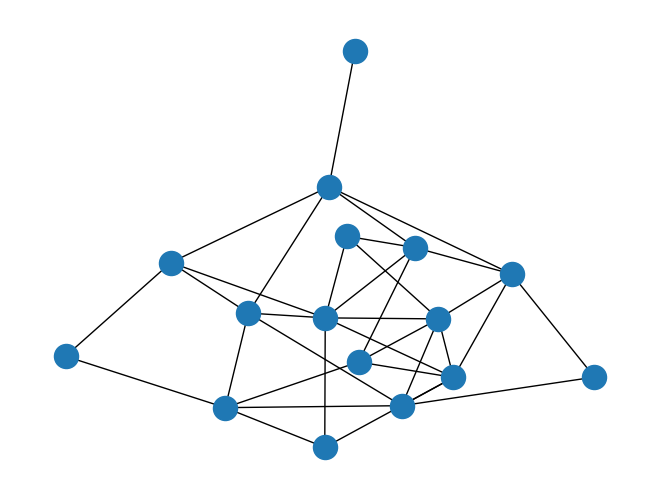

In [10]:
N = 10
p = 0.3
random_graph = gnp_random_graph(N, p)

# Visualizar el grafo
G = gnp_random_graph(16, 0.3)
nx.draw(G)
print('El Grafo tiene', G.number_of_edges(), 'aristas.')

Ejecute la celda anterior varias veces y observe que el número de aristas varía ligeramente entre los grafos aleatorios generados con los mismos parámetros. Esto se debe a que cada par de nodos tiene una probabilidad independiente de ser una arista.

## Erdös-Rényi modelo N,M

En lugar de especificar la probabilidad de enlace $p$, también podemos generar un grafo de $N$ nodos con exactamente $M$ aristas usando `random.sample()` para elegir M de las posibles aristas generadas con `itertools.combinations()`:


In [11]:
def gnm_random_graph(N, M):
    G = nx.Graph()
    G.add_nodes_from(range(N))

    possible_edges = itertools.combinations(G.nodes, 2)
    edges_to_add = random.sample(list(possible_edges), M)
    G.add_edges_from(edges_to_add)

    return G

El Grafo tiene 100 aristas.


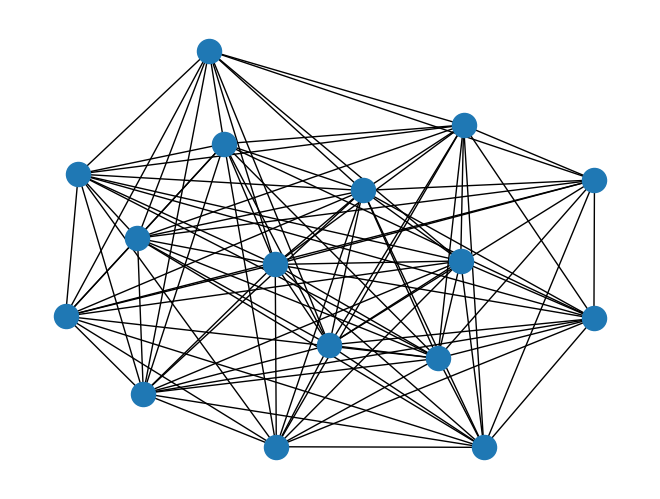

In [12]:
G = gnm_random_graph(16, 100)
print('El Grafo tiene', G.number_of_edges(), 'aristas.')
nx.draw(G)

## Funciones de NetworkX

 NetworkX tiene una función para el grafo aleatorio $G_{n,p}$ que especifica el número de nodos $N$ y la probabilidad de enlace $p$: [gnp_random_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnp_random_graph.html).

Además, NetworkX proporciona [gnm_random_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnm_random_graph.html), que genera un grafo $G_{n,m}$, donde especificamos el número de nodos $N$ y el número deseado de aristas $M$.


#Propiedades esperadas grafo Erdös-Rényi.

Aunque en general para un grafo de la vida real no es cierto que todas las aristas tienen la misma probabilidad de existir, este modelo ha sido muy util en términos teóricos para entender los límites de los grafos, especialmente en aplicaciones físicas. Para estudiar mejor los modelos que estudiaremos, podemos analizar sus propiedades desde un punto de vista probabilístico.

Dado que cualquier propiedad en un grafo aleatorio es una variable aleatoria, podemos calcular la esperanza de dicha variable para comprender su comportamiento.

## Cantidad de aristas esperadas

Para calcular una cantidad esperada podemos utilizar la Ley de los Grandes Números que nos dice que el promedio empírico converge a la esperanza teórica.

$\mathbb{E}(|E(G)|) = \dfrac{p|V(G)|(|V(G)|-1)}{2}$

In [13]:
import numpy as np

#Definamos la cantidad de vertices y la probabilidad de conexión
n_nodos = 10
p = 0.5

# Calculamos la Cantidad de aristas esperadas teórica
E_teorica = p * n_nodos*(n_nodos-1)/2

# Creamos m grafos y contamos sus aristas para calcular el promedio
m = 100
n_edge = np.array([nx.gnp_random_graph(n_nodos, p).number_of_edges() for i in range(m)])
print("El promedio de aristas es: ", np.mean(n_edge), " , la esperanza teórica es:", E_teorica)

El promedio de aristas es:  22.24  , la esperanza teórica es: 22.5


A medida que las cantidad de repeticiones (m) crece la aproximación es mejor.

## Densidad Esperada

$\mathbb{E}(density(G)) = \dfrac{\mathbb{E}(|E(G)|)}{|V(G)|(|V(G)|-1)} = p$

In [14]:
#Definamos la cantidad de vertices y la probabilidad de conexión
n_nodos = 10
p = 0.5

# Calculamos la densidad esperada teórica
E_teorica = p

# Creamos m grafos y contamos sus aristas para calcular el promedio
m = 100
n_density = np.array([nx.density(nx.gnp_random_graph(n_nodos, p)) for i in range(m)])
print("El promedio de las densidades es: ", np.mean(n_density), " , la esperanza teórica es:", E_teorica)

El promedio de las densidades es:  0.5024444444444445  , la esperanza teórica es: 0.5


## Grado promedio esperado

$\mathbb{E}(AvgDegree(G)) = \dfrac{\mathbb{E}(\sum_{v\in V(G)} Degree(v,G))}{|V(G)|}= \dfrac{\mathbb{E}(2|E(G)|)}{|V(G)|}= p (|V(G|-1)$

In [15]:
#Definamos la cantidad de vertices y la probabilidad de conexión
n_nodos = 10
p = 0.5

# Calculamos la grado promedio esperada teórica
G_teorica = p*(n_nodos-1)

# Creamos m grafos y contamos sus aristas para calcular el promedio
m = 100
n_avgdegree = np.array([np.mean(nx.degree(nx.gnp_random_graph(n_nodos, p))) for i in range(m)])
print("El promedio del grado promedio es: ", np.mean(n_avgdegree), " , la esperanza teórica es:", G_teorica)

El promedio del grado promedio es:  4.503  , la esperanza teórica es: 4.5


## Distribución de grados.

$\mathbb{P}(Deg(v,G)=k) = Binomial(p, |V(G)|-1, k), \ \ \ \forall v \in V(G)$

In [16]:
import math
#Definamos la cantidad de vertices y la probabilidad de conexión
n_nodos = 10
p = 0.5

k = 5
# Calculamos la densidad esperada teórica

P_teorica = math.comb(n_nodos-1, k)*p**k*(1-p)**(n_nodos - 1-k)

# Creamos m grafos y contamos sus aristas para calcular el promedio
m = 10000
n_prob_degree_k = np.array([nx.degree(nx.gnp_random_graph(n_nodos, p), 1)==k for i in range(m)])
print("probabilidad del grado de una arista sea k es: ", np.mean(n_prob_degree_k),
      " , la probabilidad teórica es:", P_teorica)

probabilidad del grado de una arista sea k es:  0.2487  , la probabilidad teórica es: 0.24609375


# Camino más corto
Si llamamos $l_{max}$  al largo del camino más largo en el grafo tendremos que  $l_{max}$ pasos ya habríamos llegado a todos los nodos del grafo. En otras palabras tenemos que la cantidad de nodos del grafo es aproximadamente $|V(G)| \approx k^{l_{max}}$  . Lo que implica que en un grafo aleatorio se cumple  $\dfrac{log(|V(G)|)}{log k} \approx l_{max}$  que es la definición de la small world property.

In [17]:
#Definamos la cantidad de vertices y la probabilidad de conexión
n_nodos = 10
p = 0.5

# Calculamos el grado promedio esperada teórica
G_teorica = p*(n_nodos-1)
# Calculamos la distancia máxima esperada teórica (Partimos G a la mitad al ser un grafo no direccionado).
L_teorica = np.log(n_nodos)/np.log(G_teorica/2)

# Función que calcula el camino más corto con except para camino que no existe.
def short_path_uv(G,u,v):

  try:
    return nx.shortest_path_length(G, source=u, target=v)
  except nx.NetworkXNoPath:
    return 0

# Creamos una función que calcule el camino más más corto más largo del grafo
def longest_path_G(G):
  pairs = list(itertools.combinations(G.nodes, 2))
  largo_caminos = [short_path_uv(G,u,v) for u,v in pairs]

  return max(largo_caminos)

# Creamos m grafos y contamos sus aristas para calcular el promedio
m = 100
n_longest= np.array([longest_path_G(nx.gnp_random_graph(n_nodos, p)) for i in range(m)])
print("El promedio del camino más largo es: ", np.mean(n_longest), " , la distancia máxima aproximada teórica es:", L_teorica)

El promedio del camino más largo es:  2.78  , la distancia máxima aproximada teórica es: 2.8394367936337863


# Coeficiente de Clustering
Para concluir con el análisis de los grafos de Erdos-Renyi podemos calcular el coeficiente de clustering esperado de un grafo aleatorio. Asumiendo que cada nodo tiene el mismo grado k, aplicamos la definición y obtenemos:

$\mathbb{E}(CCoeff(v,G)\approx \mathbb{E}(2\dfrac{Triangles(v,G)}{k(k-1)}) \approx p$

In [18]:
#Definamos la cantidad de vertices y la probabilidad de conexión
n_nodos = 10
p = 0.5

# Calculamos el coeficiente de clustering esperada teórica
C_teorica = p

# Creamos m grafos y contamos sus aristas para calcular el promedio
m = 100
n_cluster= np.array([nx.clustering(nx.gnp_random_graph(n_nodos, p),1) for i in range(m)])
print("El promedio del coeficiente de clustering es: ", np.mean(n_cluster), " , la esperanza teórica es:", C_teorica)


El promedio del coeficiente de clustering es:  0.4893571428571429  , la esperanza teórica es: 0.5
